# Realtore 
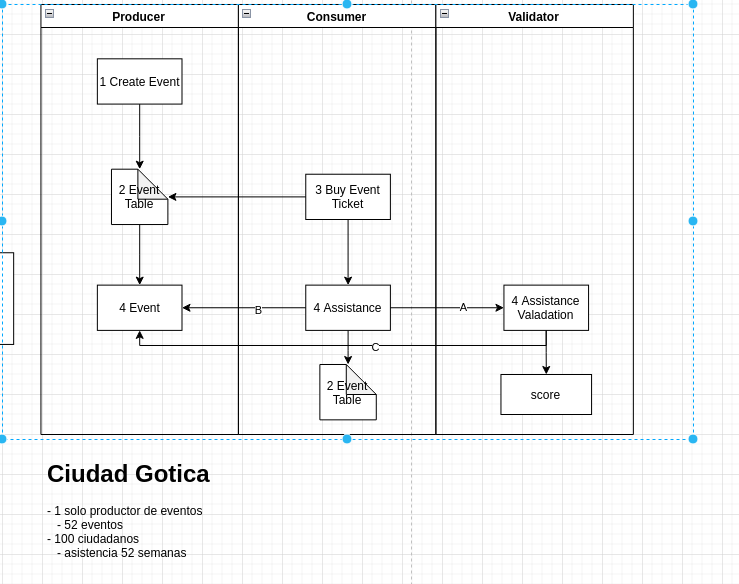
## Todo:
- Determine Token price ponderator
- Plot tables
- Widget events - spike
- check: 
   - https://bamboolib.8080labs.com/
   - https://docs.trymito.io/
   - https://www.openlaw.io/
   - https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html
  
## Roadmap
- Complete tables 
- Token prices
- Ponderators
- Set sensibility analysis



## UML

In [49]:
import iplantuml


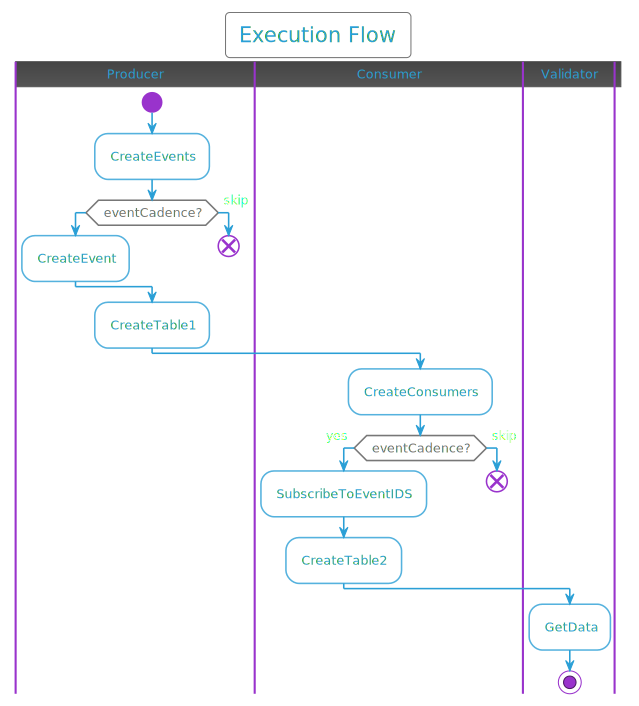

In [50]:

%%plantuml

@startuml
' https://plantuml.com/activity-diagram-beta
' !include https://raw.githubusercontent.com/bschwarz/puml-themes/master/themes/sketchy/puml-theme-sketchy.puml
!include https://raw.githubusercontent.com/bschwarz/puml-themes/master/themes/cyborg-outline/puml-theme-cyborg-outline.puml
' !include https://raw.githubusercontent.com/bschwarz/puml-themes/master/themes/cyborg-outline/puml-theme-cyborg-outline.puml


title Execution Flow

|Producer|
|Consumer|
|Validator|

|Producer|
start
:CreateEvents;
if (eventCadence?)
    :CreateEvent;
else (skip)
    end
endif
:CreateTable1;
|Consumer|
:CreateConsumers;
if (eventCadence?) then (yes)
    :SubscribeToEventIDS;
    :CreateTable2;
else (skip)
    end
endif
|Validator|
:GetData;

stop
@enduml


# CODE


In [51]:
import pandas as pd
import numpy  as np
from datetime import datetime


#pd.set_option("display.max_rows", None) # "display.max_columns", None)
pd.set_option("max_colwidth", 32)

# HELPERS
createYear   = lambda x=1,year=datetime.now().year: pd.date_range(start=f'{year+x}-01-01', end=f'{year+x+1}-01-01',freq='D')
lastDayMonth = pd.Period(datetime.now().strftime("%Y-%m")).days_in_month
daysInYear   = pd.Period(datetime.now().strftime("%Y")).day_of_year


## Producer

In [52]:
def _actor_producer(eventSize1=100,
                    eventSize2=200, 
                    EVENT_CADENCE=2,
                    FIXED=True, F=100):
    """
    producer creates events
    TODO function calculates detail once year is in place
        - add final detail https://numpy.org/doc/stable/reference/generated/numpy.split.html
    R event size - fixed
    R add more effective event uid taken hash from all columns
    R single mode, weekly , review consumer  
    
    TODO SELECT PARAMETRIZABLE VALUES
       - DATE, EVENTSIZE, EVENT_CADENCE
       
    R  cum percentage per event and per cycle
    TODO Second pivot table with insights
    """
    # FX Helpers
    def create_events(EVENT_CADENCE=EVENT_CADENCE):
        if EVENT_CADENCE == 1:
            # ON FRI
            return [1 if i.weekday() == 5 else 0 for i in df.index.date ]
        elif EVENT_CADENCE == 2:
            # ON WEEKEND
            return [1 if i.weekday() >= 5 else 0 for i in df.index.date ]
            # RANDOM OVER THE WEEK
        elif EVENT_CADENCE > 2:
            ARRAY_DAYS    = np.random.choice(np.arange(EVENT_CADENCE), EVENT_CADENCE, replace=False)
            return [1 if int(i.weekday()) in ARRAY_DAYS else 0 for i in df.index.date ]
    
    def create_eventSize(FIXED, F):
        if not FIXED:
            return np.random.randint(eventSize1,eventSize2)
        if FIXED:
            return F

    # INIT
    df = pd.DataFrame(index=np.arange(daysInYear+1), columns=['Events', 
                                                              'EventSize', 
                                                              'Producers', 
                                                              'Date'])
    
    # FIXED DATE - 1 year 
    df['Date']      = createYear()
    df.set_index('Date', inplace=True)

    df['Events']    = create_events()
    df['EventSize'] = df.loc[(df.Events == 1), 'EventSize'].apply(lambda x: int(create_eventSize(FIXED,F)) )
    #df['Event'] = np.where((df.Event == 'Painting'),'Art',df.Event)
    df['EventSize']     = df['EventSize'].fillna(0)
    df['EventSize']     = df['EventSize'].apply(int)
    df['AvailableTkts'] = df['EventSize']
    df['TotalEvents']   = df['Events'].cumsum() 
    df['Producers']     = np.where(df['Events'] == 1, "Max DJ", "")
    df['Id']            = np.where(df.EventSize == 0, 0,  df.TotalEvents )    
    df['Tkt%']          = df.apply(lambda x: x['AvailableTkts']*100/ x['EventSize'] if x['EventSize'] != 0 else 0, axis=1)
    df['Tkt%']          = df['Tkt%'].apply( lambda x: f"{x:.2f}") # Format float
    df['Cum%']          = 100*(df['AvailableTkts'].cumsum() / df['AvailableTkts'].sum())
    df['Cum%']          = df['Cum%'].apply( lambda x: f"{x:.2f}") # Format float
    
    #df.replace(0, np.nan, inplace=True)

    return df


## Consumer

In [62]:
def _actor_consumer(producer_table, 
                    P_BUY=0.6, 
                    P_ASSIST=0.98, 
                    EVENT_CADENCE=2, 
                    USERS_SIZE=100):
    """
    P_BUY    : a value between 0.1 - 0.9
    P_ASSIST : a value between 0.1 - 0.9 usually 0.92 - 0.98
    
    consumers buys producer's events
    consumers can or can't attend to events
    event are associated to consumers

    TODO add distribution https://stackoverflow.com/questions/16312006/python-numpy-random-normal-only-positive-values
    
    R cum percentage 
        ? % linked to TotalEvents   : which is the correct column to cross?
        R % linked to TotalAssisted
        R % linked to TotalBuy
    R to timeseries
    
    ERROR
        - consumerBuyTickets() need to know event length 
        - avoid event depletion when ticket count is 0
    
    """
    # RATIO IS IN WEEKS
    EVENT_RATIO   = 53*EVENT_CADENCE
    
    # INIT
    df  = pd.DataFrame(columns=['Id', 'Tickets',  'Assistance']) 

    # FXs
    # PASS A EVENT ID
    getEventCount= lambda EVENT_ID: producer_table.loc[producer_table['Id'] == EVENT_ID, 'AvailableTkts'].values

    getEventAssistanceIds = lambda ID,COL="Tickets": df.index[ df[COL].apply( lambda x: ID in x ) ]
    
    def consumerBuyTickets():
        EVENT_IDS          = producer_table[producer_table['Id'] > 0]['Id'].values
        RANDOM_EVENT_RATIO = np.random.binomial(EVENT_RATIO, P_BUY)
        EVENTS             = np.random.choice(EVENT_IDS, RANDOM_EVENT_RATIO, replace=True)
        
        return EVENTS
    
    # TODO REVIEW| INCONSISTENCY WHEN 100 BUY 100 ASSISTED
    def consumerAssistance(x):
        if len(x['Tickets']) > 0: 
            EVENTS = np.random.choice(a=x['Tickets'], size=np.random.binomial(len(x['Tickets']), P_ASSIST), replace=False )
            for EVENT in EVENTS:
                EVENT_AVAILABILITY = getEventCount(EVENT)
                if EVENT_AVAILABILITY > 0:
                    producer_table.loc[producer_table['Id'] == EVENT, 'AvailableTkts'] -= 1
                else:
                    EVENTS = np.delete(EVENTS, np.where(EVENTS == EVENT))
            return EVENTS
        else:
            return []
        
    # TABLE 1
    df['Id']         = np.arange(USERS_SIZE)
    df['Tickets']    = df['Tickets'].apply( lambda x: sorted(consumerBuyTickets())  )
    df['Assistance'] = df.apply( lambda x: sorted(consumerAssistance(x)), axis=1 )
    df['NotShowed']  = df['Tickets'].map(set) - df['Assistance'].map(set)
    df['NotShowed']  = df['NotShowed'].apply(list)
    df['NotShowed']  = df['NotShowed'].apply( lambda x: [len(x), x]) 

    df['TotalAssisted'] = df.apply( lambda x: len(df['Tickets'][x.name]) - x['NotShowed'][0], axis=1 )  
    df['TotalBuy']      = df.apply( lambda x: len(df['Tickets'][x.name]) , axis=1 )
    df['TotalEvents']   = producer_table['TotalEvents'][-1] 
    df['AsistanceBuy%'] = df.apply( lambda x: (int(x['TotalAssisted']*100/x['TotalBuy']) if x['TotalAssisted'] != 0 else 0 ) ,axis=1)
    df['EventsBuy%']    = df.apply( lambda x: (int(x['TotalBuy']*100/x['TotalEvents']) if x['TotalAssisted'] != 0 else 0 ) ,axis=1)
    
    
    # TABLE 2
    df2               = pd.DataFrame({"Event": producer_table['Id']})
    df2["Buy"]        = df2["Event"].apply(lambda ID: [len(list(getEventAssistanceIds(ID))),list(getEventAssistanceIds(ID))] if ID != 0 else ID )
    df2["Assisted"]   = df2["Event"].apply(lambda ID: [len(list(getEventAssistanceIds(ID,"Assistance"))),list(getEventAssistanceIds(ID))] if ID != 0 else ID )
    df2['EventSize']  = producer_table['EventSize']

    # UPDATE PRODUCER_TABLE
    producer_table["UserList"] = producer_table["Id"].apply(lambda ID: [len(list(getEventAssistanceIds(ID))),list(getEventAssistanceIds(ID))] if ID != 0 else ID )
    
    return df,df2


## Validator

In [63]:
def _actor_validator(consumer_table,producer_table,EVENT_CADENCE=2):
    """
    validator check consumer assistance
    R consumer tracking aka loyalty
    R ranked user    
    TODO get assistence from consumer 
        - create multi index table 
        - create event detail from user tickets  
    TODO SELECT PARAMETRIZABLE VALUES
    
    TODO import producer table
    TODO events in time
        - events per user
            - column is user
            - index
    TODO add correct detail
    TODO % average anual, 
        - event assiantance avg
        - event cumsum per event
        - event cumsum per consumer
    """
    EVENT_RATIO   = (52*EVENT_CADENCE)
    # FX
    def getEventAssistance(EVENT): 
        # SIGNAL STYLE
        result = consumer_table['Tickets'].apply(lambda x: (1 if EVENT in x else 0) )
        result = result.sum()
        return  result
    
    # eventCols = ["Event"+str(i) for i in range(1,consumer_table['TotalBuy'].iloc[-1]) ]
    
    def getEventSizePercentage():
        def func(x):
            if x['EventSize'] != 0:
                RESULT = ((x['EventSize'] - x['AvailableTkts'])*100) / x['EventSize'] 
                return RESULT
            else:
                return 0
        return producer_table.apply(func, axis=1)

    # INIT
    df  = pd.DataFrame(columns=['Id', 'UserId', 'Assistance%']) 
#     df2 = pd.DataFrame(index=[1],columns=eventCols)

#     df['Id']          = np.arange(len(consumer_table))
#     df['UserId']      = consumer_table['Id']
#     df['Assistance%'] = df.apply(lambda x: f"{((int(consumer_table['TotalAssisted'][x.name])*100)/EVENT_RATIO):.2f}", axis=1)
#     df['Rank']        = sorted(df['Assistance%'], reverse=True)
    
#     for EVENT in range(1,consumer_table['TotalBuy'].iloc[-1]):
#        df2["Event"+str(EVENT)] = getEventAssistance(EVENT).sum()

    df = df.sort_values(by='Assistance%', ascending=False)
    
    # PRODUCER
    producer_table['Tkt%'] = getEventSizePercentage()

    return df #,df2



In [55]:
# %matplotlib inline
# from ipywidgets import interactive
# import matplotlib.pyplot as plt
# import numpy as np

# def f(m, b):
#     plt.figure(2)
#     x = np.linspace(-10, 10, num=1000)
#     plt.plot(x, m * x + b)
#     plt.ylim(-5, 5)
#     plt.show()

# interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

## Dashboard


In [64]:
from IPython.display import display
from ipywidgets import interact,interactive,interactive_output
import ipywidgets as widgets

#from pivottablejs import pivot_ui

#!pip3 install pivottablejs
#!pip3 install qgrid
#!pip3 install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

# TODO replace Consume - P_XXX Select to IntSlide 


widgets.Output(layout={'border': '1px solid black', 'width': '1600px', 'height': '100%', 'overflow': 'scroll', 'display': 'flex', 'flex_flow': 'row'})

# PRODUCER BUTTONS
eventSize1    = widgets.IntSlider(description="eventSizeMin", min=10,  max=99,  step=10, value=100, continuous_update=False)
eventSize2    = widgets.IntSlider(description="eventSizeMax", min=100, max=200, step=10, value=100, continuous_update=False)
EVENT_CADENCE = widgets.IntSlider(description="Cadence", min=1,   max=7,   value=1, continuous_update=False)
FIXED         = widgets.Checkbox( value=True, description='FixedValue 100')
F             = widgets.IntSlider(description='FixedVal', min=50, max=500, step=50, value=100, continuous_update=False)

# CONSUMER BUTTONS
P_BUY      = widgets.Dropdown(description="P_BUY",    options=[("ExtremePessimist",0.05),
                                                               ("Pessimist",0.21),
                                                               ("Balanced", 0.66), 
                                                               ("Optimist",0.94), 
                                                               ("VeryOptimist",0.97), 
                                                               ("ExtremeOptimist", 0.99),
                                                               ("FIXED",1)], value=1)
P_ASSIST   = widgets.Dropdown(description="P_ASSIST", options=[("ExtremePessimist",0.05),
                                                               ("Pessimist",0.33),
                                                               ("Balanced", 0.96),
                                                               ("Optimist",0.97),
                                                               ("VeryOptimist",0.98),
                                                               ("ExtremeOptimist",0.999),
                                                               ("FIXED",1)], value=1)
FIXED_USR  = widgets.Checkbox( value=True, description='FixedValue 100')
USERS_SIZE = widgets.IntSlider(description="UserSize", min=10, max=500, step=10, value=100)

VALIDATION = widgets.Checkbox( value=False, description='ValidatorTable')


# UI BUTTONS
TABLE      = widgets.Dropdown(description="Table",    options=['Producers','Consumers','Validators'], value='Producers')
RENDER     = widgets.Checkbox( value=False, description='RENDER')
SLIDE      = widgets.IntSlider(description="SubTables", min=0, max=2,value=0, continuous_update=False)

#@interact(eventSize1=(20,100),eventSize2=(0,200))
def main(eventSize1,
         eventSize2,
         FIXED, 
         F,
         P_BUY,P_ASSIST,
         TABLE,
         VALIDATION,
         EVENT_CADENCE,
         USERS_SIZE,
         FIXED_USR,
         SLIDE,
         RENDER):
    """
    R: Make it plotable wise instead of table wise
    """
    global producer, consumer, validator
    #print(scene)
    
    if RENDER:
        producer  = _actor_producer(eventSize1,
                                    eventSize2,
                                    EVENT_CADENCE,
                                    FIXED,
                                    F)
        consumer  = _actor_consumer(producer, 
                                    P_BUY=P_BUY, 
                                    P_ASSIST=P_ASSIST,
                                    EVENT_CADENCE=EVENT_CADENCE,
                                    USERS_SIZE=USERS_SIZE)
        validator = _actor_validator(consumer,
                                     producer,
                                     EVENT_CADENCE=EVENT_CADENCE)
    #c = pivot_ui(c)
    
    if TABLE == "Producers":
        #producer = pivot_ui(producer)
        display(producer)
    elif TABLE == "Consumers":
        #consumer = pivot_ui(consumer)
        display(consumer[SLIDE])
    elif TABLE =="Validators":
        display(validator)



#ui = widgets.VBox([eventSize1, eventSize2, P_BUY, P_ASSIST,TABLE])
out = widgets.interactive_output(main, {
    'eventSize1': eventSize1, 
    'eventSize2': eventSize2,
    'FIXED'     : FIXED,
    'F'         : F,
    'EVENT_CADENCE': EVENT_CADENCE,    
    'P_BUY'     : P_BUY,
    'P_ASSIST'  : P_ASSIST,
    'TABLE'     : TABLE,
    'USERS_SIZE': USERS_SIZE,
    'VALIDATION': VALIDATION,
    'FIXED_USR' : FIXED_USR,
    'SLIDE'     : SLIDE,
    'RENDER'    : RENDER
})


# MAIN
#display(ui, out)
box1      = widgets.VBox([eventSize1, eventSize2, EVENT_CADENCE, FIXED, F])
box2      = widgets.VBox([P_BUY, P_ASSIST, USERS_SIZE,FIXED_USR])
children  = [box1,box2,VALIDATION]
tab       = widgets.Tab()
tab.children = children
tab.titles   = ["producer", "consumer", "Validator"]

# MAIN WINDOW
#display(TABLE,SLIDE,tab,out)


#display(producer_out)


#pivot_ui(_actor_producer(10,20))

### Command Control

In [65]:
display(RENDER,TABLE,SLIDE,tab)


Checkbox(value=False, description='RENDER')

Dropdown(description='Table', options=('Producers', 'Consumers', 'Validators'), value='Producers')

IntSlider(value=0, continuous_update=False, description='SubTables', max=2)

In [66]:
display(out)

Output()

In [67]:
print(producer["EventSize"])

Date
2023-01-01      0
2023-01-02      0
2023-01-03      0
2023-01-04      0
2023-01-05      0
             ... 
2023-12-28      0
2023-12-29      0
2023-12-30    100
2023-12-31      0
2024-01-01      0
Name: EventSize, Length: 366, dtype: int64


Output()

IntSlider(value=0, description='PlotSlide', max=2)

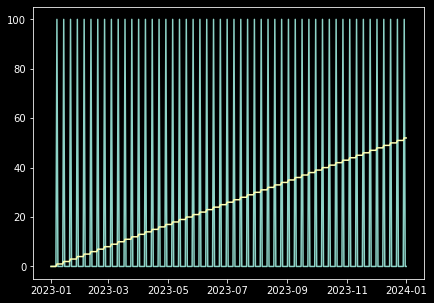

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#print(np.where(producer["UserList"] != 0, 0, 1))
PLOT_SLIDE = widgets.IntSlider(min=0,max=2,value=0,description="PlotSlide")


def plot(**kwargs):
    plt.style.use('dark_background')
    plt.figure(figsize=(7,5))
    plt.plot(producer.index, producer["AvailableTkts"], label="TKTS")
    plt.plot(producer.index, producer["TotalEvents"],   label="Events")
    USERS = producer["UserList"].map(lambda x: x[0] if x != 0 else 0 ).values
    plt.plot(producer.index[USERS], USERS,   label="Events")
    #y = np.where(producer["UserList"] != 0, producer["UserList"], producer["UserList"])
    #print(y)
    #plt.plot(producer.index, y, label="TKTS",color='cyan')
    plt.legend()
    plt.show()

    #producer.plot()
    
plot = widgets.interactive_output(plot, {
    'eventSize1': eventSize1, 
    'eventSize2': eventSize2,
    'FIXED'     : FIXED,
    'F'         : F,
    'EVENT_CADENCE': EVENT_CADENCE,    
    'P_BUY'     : P_BUY,
    'P_ASSIST'  : P_ASSIST,
    'TABLE'     : TABLE,
    'USERS_SIZE': USERS_SIZE,
    'VALIDATION': VALIDATION,
    'FIXED_USR' : FIXED_USR,
    'SLIDE'     : SLIDE,
    'PLOT_SLIDE': PLOT_SLIDE
})

display(plot, PLOT_SLIDE)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87b8e1ec10>,
      dtype=object)

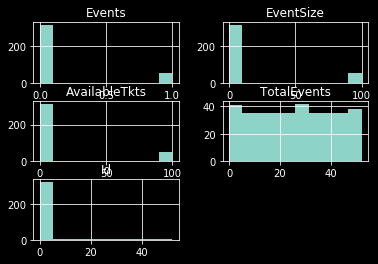

In [ ]:

# import itables.options as opt


# display(HTML("""
# <script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2k.1.10/require.min.js"></script>
# <script>

# </script>
# """))
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

# opt.classes = ["display", "nowrap"]

#USERS=producer["UserList"].map(lambda x: x[0] if x != 0 else 0 ).values
#producer.plot.style.use('dark_background')
#producer.plot.figure(figsize=(10,8))
#producer.plot(producer.index, USERS, label="Events", color="Blue")
#producer.plot.legend()
#producer.plot.show()
producer.hist()

